In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model


In [51]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [31]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
DATA_DIR = "C:/Users/Iman/Desktop/Fruits Classification"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR = os.path.join(DATA_DIR, "test")
CALORIE_MAP = {
    "Apple": 52,
    "Banana": 89,
    "Grape": 67,
    "Mango": 60,
    "Strawberry": 33
}


In [33]:
def explore_dataset(directory):
    classes = os.listdir(directory)
    class_counts = {}
    plt.figure(figsize=(15, 10))
    
    for i, cls in enumerate(classes):
        class_path = os.path.join(directory, cls)
        class_counts[cls] = len(os.listdir(class_path))
        
        # Display sample image
        img_path = os.path.join(class_path, os.listdir(class_path)[0])
        img = load_img(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"{cls}\n{class_counts[cls]} images")
        plt.axis('off')
    
    plt.suptitle("Dataset Samples and Class Distribution", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Plot class distribution
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title("Class Distribution")
    plt.xlabel("Fruit Classes")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45)
    plt.show()
    
    return class_counts


In [35]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 9700 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


In [27]:
class_names = ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
dataset_dir = "C:/Users/Iman/Desktop/Fruits Classification/train"

# Then run your loop
for i, cls in enumerate(class_names):
    class_path = "C:/Users/Iman/Desktop/Fruits Classification"
    img_path = os.path.join(class_path, os.listdir(class_path)[0])
    img = load_img(img_path)
    
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"{cls}\n{len(os.listdir(class_path))} images")
    plt.axis('off')

plt.suptitle("Dataset Samples and Class Distribution", fontsize=16)
plt.tight_layout()
plt.show()


NameError: name 'os' is not defined

In [25]:
# === ENHANCED DATA AUGMENTATION ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [27]:
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

Found 9700 images belonging to 5 classes.


In [29]:
val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 200 images belonging to 5 classes.


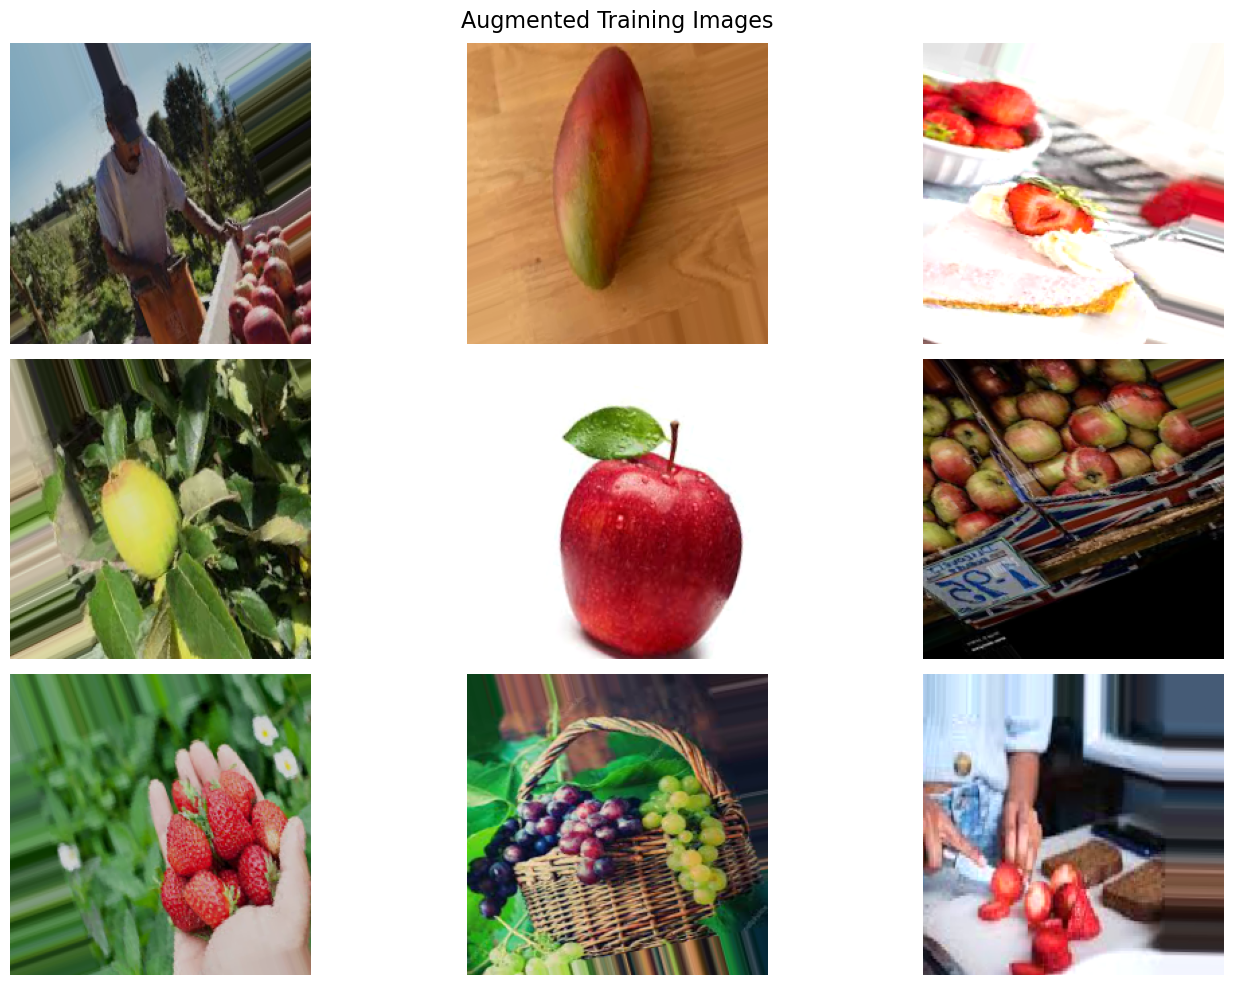

In [31]:
# Visualize augmented images
def plot_augmented_images(generator):
    plt.figure(figsize=(15, 10))
    for X_batch, y_batch in generator:
        for i in range(9):
            plt.subplot(3, 3, i+1)
            plt.imshow(X_batch[i])
            plt.axis('off')
        plt.suptitle("Augmented Training Images", fontsize=16)
        plt.tight_layout()
        plt.show()
        break

plot_augmented_images(train_gen)

In [33]:
# === ENHANCED MODEL ARCHITECTURE ===
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    alpha=0.35  # Smaller model
)

2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 2s 1us/step


In [35]:
# Freeze base layers (Transfer Learning - Day 05)
base_model.trainable = False

In [41]:
# Build model with BatchNorm and more layers (CNN Concepts - Day 04)
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

In [1]:
# Visualize model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True)

NameError: name 'plot_model' is not defined

In [3]:
# === CALLBACKS (Workflow - Day 06) ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

NameError: name 'EarlyStopping' is not defined

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# === TRAINING ===
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=EPOCHS,
    callbacks=callbacks
)

In [ ]:
# === VISUALIZE TRAINING ===
def plot_training_history(history):
    plt.figure(figsize=(15, 5))

In [ ]:
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

In [ ]:
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# === EVALUATION ===
test_gen = val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

In [ ]:
# Generate predictions
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

In [ ]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(y_true, y_pred_classes, class_names)

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

In [ ]:
# === PREDICTION FUNCTION WITH VISUALIZATION ===
def predict_fruit_and_calories(img_path, show_image=True):
    model = load_model('best_model.h5')
    class_names = list(train_gen.class_indices.keys())

In [ ]:
    # Load and preprocess image
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

In [ ]:
    # Make prediction
    prediction = model.predict(img_array)[0]
    label_index = np.argmax(prediction)
    label = class_names[label_index]
    confidence = np.max(prediction)
    calories = CALORIE_MAP.get(label, "Unknown")

In [ ]:
    # Visualization
    if show_image:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"Predicted: {label}\nConfidence: {confidence:.2f}\nCalories: {calories} kcal/100g")
        plt.axis('off')
        plt.show()

In [ ]:
    # Print results
    print("\nPrediction Results:")
    print(f"Predicted Fruit: {label} (Confidence: {confidence:.2%})")
    print(f"Estimated Calories: {calories} kcal per 100g")

In [ ]:
    # Show class probabilities
    plt.figure(figsize=(10, 4))
    sns.barplot(x=class_names, y=prediction)
    plt.title('Class Probabilities')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    plt.show()
    
    return label, calories

In [ ]:
# Example usage:
# predict_fruit_and_calories(os.path.join(TEST_DIR, "Apple/1001_100.jpg"))